### DataFrame Transformations
---------
The material in this notebook was extracted from
* Spark The Definitive Guida Big Data Processing Made Simple (2018)
---------

When working with individual DataFrames, there are some fundamental objectives. These break donw into several core operations:

- Add rows or columns
- Remove rows or columns
- Transform rows into columns (or vice versa)
- Sort data by values

![alt text](./imgs/transformations.png "Logo Title Text 1")


In [ ]:
!apt-get install openjdk-8-jdk -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
from google.colab import drive, auth
findspark.init("spark-3.0.2-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark =  SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH='/content/'

#### Creating DataFrames

We can create DataFrames from raw data sources

In [ ]:
#DATA_PATH='/Users/luis/Documents/Work/Telefonica/Courses/DATA/' 
df = spark.read\
.format('csv')\
.option('header', True)\
.option('inferSchema', True)\
.load(DATA_PATH + 'flights.csv')

In [ ]:
print(df.count(), len(df.columns))

5819079 31


But we can also create DataFrames on the fly

In [ ]:
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType

mySchema = StructType([
    StructField('some', StringType(), True),
    StructField('col', StringType(), True),
    StructField('names', LongType(), False)
])

myRows = [Row('Hello', None, 1), 
          Row('World', '!', 2), 
          Row('HOW', None, 3)]


myDf = spark.createDataFrame(myRows, mySchema)
myDf.show()

+-----+----+-----+
| some| col|names|
+-----+----+-----+
|Hello|null|    1|
|World|   !|    2|
|  HOW|null|    3|
+-----+----+-----+



##### Select and selectExpr

```select``` and ```selectExpr```allow you to do the DataFrame equivalent of SQL queries on a table

In [ ]:
df.select('DESTINATION_AIRPORT').show(2)

+-------------------+
|DESTINATION_AIRPORT|
+-------------------+
|                SEA|
|                PBI|
+-------------------+
only showing top 2 rows



In [ ]:
df.select('DESTINATION_AIRPORT', 'AIR_TIME').show(2)  

+-------------------+--------+
|DESTINATION_AIRPORT|AIR_TIME|
+-------------------+--------+
|                SEA|     169|
|                PBI|     263|
+-------------------+--------+
only showing top 2 rows



You can refer columns in multiple ways

In [ ]:
from pyspark.sql.functions import expr, col, column, lit
df.select(
    expr('DESTINATION_AIRPORT'),
    col('ORIGIN_AIRPORT'),
    column('DISTANCE')).show(2)

+-------------------+--------------+--------+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|DISTANCE|
+-------------------+--------------+--------+
|                SEA|           ANC|    1448|
|                PBI|           LAX|    2330|
+-------------------+--------------+--------+
only showing top 2 rows



And with a little bit more flexibility

In [ ]:
# df.select(expr(...))
df.selectExpr(
    '*', # Include all original columns
    'DESTINATION_AIRPORT as destiny',
    'DISTANCE*2 as round_trip').show(2)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+-------+----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|destiny|round_trip|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+

In [ ]:
df1 = df.cache()
df1.selectExpr(
    'DESTINATION_AIRPORT as destiny',
    'ORIGIN_AIRPORT',
    'DISTANCE',
    'DISTANCE < 1000 as near_by').filter(col('near_by')).show(5)

+-------+--------------+--------+-------+
|destiny|ORIGIN_AIRPORT|DISTANCE|near_by|
+-------+--------------+--------+-------+
|    DFW|           PHX|     868|   true|
|    DFW|           PHX|     868|   true|
|    SEA|           GEG|     224|   true|
|    ITO|           HNL|     216|   true|
|    SFO|           ONT|     363|   true|
+-------+--------------+--------+-------+
only showing top 5 rows



With ```selectExpr```we can also compute aggregates

In [ ]:
df1.selectExpr('avg(DISTANCE) as mean_distance', 
               'count(distinct(ORIGIN_AIRPORT)) as dist_org', 
               'count(distinct(DESTINATION_AIRPORT)) as dist_dest').show()

+-----------------+--------+---------+
|    mean_distance|dist_org|dist_dest|
+-----------------+--------+---------+
|822.3564947305235|     628|      629|
+-----------------+--------+---------+



##### Adding Columns

We can add columns to a Spark DataFrame within the select statement:

In [ ]:
df1.select(col('ORIGIN_AIRPORT'), 
           lit(33).alias('Two')).show(4)

+--------------+---+
|ORIGIN_AIRPORT|Two|
+--------------+---+
|           ANC| 33|
|           LAX| 33|
|           SFO| 33|
|           LAX| 33|
+--------------+---+
only showing top 4 rows



Or using the more formal function ```withColumn```

In [ ]:
df.select(col('ORIGIN_AIRPORT')).withColumn('One', lit(1)).show(2)

+--------------+---+
|ORIGIN_AIRPORT|One|
+--------------+---+
|           ANC|  1|
|           LAX|  1|
+--------------+---+
only showing top 2 rows



In [ ]:
from pyspark.sql.functions import udf, avg
from pyspark.sql.types import IntegerType
# ------------------------------
# F.when!
how_far = udf(lambda x: 'near' if x < 500 else 'no so near' 
              if x < 1000 else 'far away')
f_desc  = udf(lambda x, y, z: -100 if (float(x) > float(y) 
              and z == 'far away') else
             -1000 if (float(x) > float(y) and z == 'no so near') else 
             -1500 if float(x) > float(y) else 0, IntegerType())
# ------------------------------
df.select('origin', 'dest', 
          'distance', 'arr_delay')\
.withColumn('mean_delay', 
            lit(df.agg(avg('arr_delay')).take(1)[0][0]))\
.withColumn('cat_dist', how_far(col('distance')))\
.withColumn('descuento', f_desc(col('arr_delay'),
                                col('mean_delay'),
                                col('cat_dist'))).show(15)

AnalysisException: ignored

The full functionality of ```withColumn```can be enhanced by using ```udfs```

##### Renaming columns

We can rename columns either with an alias, a ```withColumn``` or ```withColumnRenamed```

In [ ]:
df.select(col('DESTINATION_AIRPORT').alias('destiny')).show(2)

+-------+
|destiny|
+-------+
|    SEA|
|    PBI|
+-------+
only showing top 2 rows



In [ ]:
df.select('DESTINATION_AIRPORT').withColumn('destiny', col('DESTINATION_AIRPORT')).show(2)

+-------------------+-------+
|DESTINATION_AIRPORT|destiny|
+-------------------+-------+
|                SEA|    SEA|
|                PBI|    PBI|
+-------------------+-------+
only showing top 2 rows



In [ ]:
df.select('DESTINATION_AIRPORT').withColumnRenamed('DESTINATION_AIRPORT', 'destiny').show(2)

+-------+
|destiny|
+-------+
|    SEA|
|    PBI|
+-------+
only showing top 2 rows



##### Removing columns

We can remove one or multiple columns with ```drop````


In [ ]:
df.select(col('DESTINATION_AIRPORT'), 
          col('ORIGIN_AIRPORT'), 
          col('DISTANCE'), 
          expr('DISTANCE < 1000').alias('near_by')).show(2)

+-------------------+--------------+--------+-------+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|DISTANCE|near_by|
+-------------------+--------------+--------+-------+
|                SEA|           ANC|    1448|  false|
|                PBI|           LAX|    2330|  false|
+-------------------+--------------+--------+-------+
only showing top 2 rows



In [ ]:
df.select(col('DESTINATION_AIRPORT'), 
          col('ORIGIN_AIRPORT'), 
          col('DISTANCE'), 
          expr('DISTANCE < 1000').alias('near_by')).drop('DESTINATION_AIRPORT').show(2)

+--------------+--------+-------+
|ORIGIN_AIRPORT|DISTANCE|near_by|
+--------------+--------+-------+
|           ANC|    1448|  false|
|           LAX|    2330|  false|
+--------------+--------+-------+
only showing top 2 rows



In [ ]:
df.select(col('DESTINATION_AIRPORT'), 
          col('ORIGIN_AIRPORT'), 
          col('DISTANCE'), 
          expr('DISTANCE < 1000').alias('near_by')).drop('DESTINATION_AIRPORT', 'ORIGIN_AIRPORT').show(2)

+--------+-------+
|DISTANCE|near_by|
+--------+-------+
|    1448|  false|
|    2330|  false|
+--------+-------+
only showing top 2 rows



##### Changing a Column's type


In [ ]:
df.select(col('DISTANCE').cast('float')).show(2)

+--------+
|DISTANCE|
+--------+
|  1448.0|
|  2330.0|
+--------+
only showing top 2 rows



##### Filtering rows

In [ ]:
df.select(col('DESTINATION_AIRPORT'), 
          col('ORIGIN_AIRPORT'), 
          col('DISTANCE'), 
          expr('DISTANCE < 1000').alias('near_by'))\
.filter(col('near_by')).show(2)

+-------------------+--------------+--------+-------+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|DISTANCE|near_by|
+-------------------+--------------+--------+-------+
|                DFW|           PHX|     868|   true|
|                DFW|           PHX|     868|   true|
+-------------------+--------------+--------+-------+
only showing top 2 rows



In [ ]:
df.groupBy(col('DESTINATION_AIRPORT'), 
           col('ORIGIN_AIRPORT')).count().filter(col('count') > 100).show(2)

+-------------------+--------------+-----+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|count|
+-------------------+--------------+-----+
|                ATL|           GSP| 2471|
|                ORD|           PDX| 2164|
+-------------------+--------------+-----+
only showing top 2 rows



In [ ]:
df.groupBy(col('DESTINATION_AIRPORT'), 
           col('ORIGIN_AIRPORT')).count()\
.where(col('count') > 100).show(2)

+-------------------+--------------+-----+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|count|
+-------------------+--------------+-----+
|                ATL|           GSP| 2471|
|                ORD|           PDX| 2164|
+-------------------+--------------+-----+
only showing top 2 rows



In [ ]:
df.groupBy(col('DESTINATION_AIRPORT'), 
           col('ORIGIN_AIRPORT')).count()\
.where(col('count') > 100)\
.where(col('count') < 1000).show(2)

+-------------------+--------------+-----+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|count|
+-------------------+--------------+-----+
|                PBI|           DCA|  978|
|                MDW|           MEM|  626|
+-------------------+--------------+-----+
only showing top 2 rows



##### Getting unique rows

In [ ]:
df.select('DESTINATION_AIRPORT', 'ORIGIN_AIRPORT').distinct().show(5)

+-------------------+--------------+
|DESTINATION_AIRPORT|ORIGIN_AIRPORT|
+-------------------+--------------+
|                ATL|           GSP|
|                ORD|           PDX|
|                PBI|           DCA|
|                MDW|           MEM|
|                SNA|           PHX|
+-------------------+--------------+
only showing top 5 rows



##### Aggregations and Grouping with maps

In [ ]:
from pyspark.sql.functions import col, count, countDistinct, approx_count_distinct, first, last, min, max, sum, sumDistinct, avg, collect_set, collect_list

The first function worth going over is **count**, with the sole exception that in this example it will perform as a transformation instead of an action. 

In [ ]:
from pyspark.sql.functions import col, count, countDistinct, approx_count_distinct, first, last, min, max, sum, sumDistinct, avg, collect_set, collect_list

df.select(count('AIRLINE').alias('all_airlines')).show()

+------------+
|all_airlines|
+------------+
|     5819079|
+------------+



Sometimes we are not interested in the total count but in the number of different instances of the variable. 

In [ ]:
df.select(countDistinct('AIRLINE').alias('unique_carriers')).show()
df.groupBy('AIRLINE').count().count()

+---------------+
|unique_carriers|
+---------------+
|             14|
+---------------+



14

If the dataset is very large, the exact count of different instances might be irrelevant, but an approximation with certain degreee of accuracy might be good enough

In [ ]:
df.select('TAIL_NUMBER').distinct().count()

4898

You can get the first and last values from a DataFrame

In [ ]:
df.select(
    first('TAIL_NUMBER').alias('first_tailnum'),
    last('TAIL_NUMBER').alias('last_tailnum')
).show()

+-------------+------------+
|first_tailnum|last_tailnum|
+-------------+------------+
|       N407AS|      N534JB|
+-------------+------------+



You can also compute the min, max, sum, avg values

In [ ]:
%%timeit -n 2

df.select(
    min(col('DISTANCE')).alias('min_distance'),
    sum(col('DISTANCE')).alias('sum_distance'),
    avg(col('DISTANCE')).alias('avg_distance'),
    max(col('DISTANCE')).alias('max_distance'),
).show()


+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_distance|
+------------+------------+-----------------+------------+
|          21|  4785357409|822.3564947305235|        4983|
+------------+------------+-----------------+------------+

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_distance|
+------------+------------+-----------------+------------+
|          21|  4785357409|822.3564947305235|        4983|
+------------+------------+-----------------+------------+

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_distance|
+------------+------------+-----------------+------------+
|          21|  4785357409|822.3564947305235|        4983|
+------------+------------+-----------------+------------+

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_dist

In [ ]:
%%timeit -n 2

df.selectExpr('min(DISTANCE) as min_distance', 
              'sum(DISTANCE) as sum_distance', 
              'avg(DISTANCE) as avg_distance',
              'max(DISTANCE) as max_distance').show()

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_distance|
+------------+------------+-----------------+------------+
|          21|  4785357409|822.3564947305235|        4983|
+------------+------------+-----------------+------------+

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_distance|
+------------+------------+-----------------+------------+
|          21|  4785357409|822.3564947305235|        4983|
+------------+------------+-----------------+------------+

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_distance|
+------------+------------+-----------------+------------+
|          21|  4785357409|822.3564947305235|        4983|
+------------+------------+-----------------+------------+

+------------+------------+-----------------+------------+
|min_distance|sum_distance|     avg_distance|max_dist

And some more complex aggregates

In [ ]:
df.select(
   collect_list('AIRLINE').alias('carriers'),
   collect_set('TAIL_NUMBER').alias('unique_planes')
).show()

+--------------------+--------------------+
|            carriers|       unique_planes|
+--------------------+--------------------+
|[AS, AA, US, AA, ...|[N557AS, N579JB, ...|
+--------------------+--------------------+



### Window Functions

Window functions allow you to apply aggregated computations through different data partitions and to interoperate them with individual registries. These are particularly useful since they allow you to get rid of loops (for, while,...).

Let's take a look at some examples:



In [ ]:
import pyspark.sql.functions as F

In [ ]:
from pyspark.sql.functions import col, avg, expr, abs, monotonically_increasing_id, ntile, sum, lit, dense_rank, collect_list
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType

So, there are multiple columns among which we could perform some interesting computations. For example, it might be of interest to know which planes tend to have larger delays than the average plane per carrier. In order to answer this question, we must perform the following steps:

* Define the fields among which we are going to partition the data in order to compute the aggregates. In this case, we are interested in the variable _carrier_

* Define the function to apply and how it is going to interplay with the individual entries. 

* Apply the function


##### Select variables of interest

In [ ]:
ex1_data = df.select(col('MONTH'),
                     col('YEAR'),
                     col('TAIL_NUMBER'), 
                     col('AIRLINE'), 
                     col('ARRIVAL_DELAY'))\
.filter(col('TAIL_NUMBER').isNotNull())\
.filter(col('ARRIVAL_DELAY').isNotNull())

ex1_data.show(5)

+-----+----+-----------+-------+-------------+
|MONTH|YEAR|TAIL_NUMBER|AIRLINE|ARRIVAL_DELAY|
+-----+----+-----------+-------+-------------+
|    1|2015|     N407AS|     AS|          -22|
|    1|2015|     N3KUAA|     AA|           -9|
|    1|2015|     N171US|     US|            5|
|    1|2015|     N3HYAA|     AA|           -9|
|    1|2015|     N527AS|     AS|          -21|
+-----+----+-----------+-------+-------------+
only showing top 5 rows



##### Determine variables for partitioning the data

In [ ]:
windowSpec = Window.partitionBy(col('AIRLINE')).orderBy(col('AIRLINE'))

##### Define function to apply


In this case we are interested in finding out how the delay of each plane compares with the average delay of the given airline, thus, we are going to compute the difference between the average and the particular delays. 


In [ ]:
average_delay = avg(ex1_data['ARRIVAL_DELAY']).over(windowSpec) 
average_delay_diff = avg(ex1_data['ARRIVAL_DELAY']).over(windowSpec) - ex1_data['ARRIVAL_DELAY']

##### Apply function

In [ ]:
ex1_data = ex1_data.select('*', 
                           average_delay.alias('AVERAGE_CARRIER_DELAY'),
                           average_delay_diff.alias('DELAY_DEVIATION'))
ex1_data.sort(col('AIRLINE'), 
              col('DELAY_DEVIATION')).show(10)

+-----+----+-----------+-------+-------------+---------------------+-------------------+
|MONTH|YEAR|TAIL_NUMBER|AIRLINE|ARRIVAL_DELAY|AVERAGE_CARRIER_DELAY|    DELAY_DEVIATION|
+-----+----+-----------+-------+-------------+---------------------+-------------------+
|    1|2015|     N598AA|     AA|         1971|   3.4513721447256764|-1967.5486278552744|
|    8|2015|     N479AA|     AA|         1898|   3.4513721447256764|-1894.5486278552744|
|    9|2015|     N3CAAA|     AA|         1665|   3.4513721447256764|-1661.5486278552744|
|   11|2015|     N489AA|     AA|         1638|   3.4513721447256764|-1634.5486278552744|
|    7|2015|     N3LEAA|     AA|         1636|   3.4513721447256764|-1632.5486278552744|
|   12|2015|     N4XKAA|     AA|         1636|   3.4513721447256764|-1632.5486278552744|
|    2|2015|     N028AA|     AA|         1627|   3.4513721447256764|-1623.5486278552744|
|    3|2015|     N559AA|     AA|         1598|   3.4513721447256764|-1594.5486278552744|
|    1|2015|     N5DG

Now we have an idea of which planes have the largest delays! Let us suppose that we are interested in comparing the top 5 planes with the largest delays between airlines. We can do this with another window function.

##### Determine variables for partitioning the data


In [ ]:
windowSpec = Window.partitionBy(ex1_data['AIRLINE']).orderBy(ex1_data['AIRLINE'], ex1_data['DELAY_DEVIATION'])

##### Define function to apply

In this case, we are interested in computing a ranking

In [ ]:
rank_func = dense_rank().over(windowSpec)

##### Apply function

In [ ]:
top_delay = 5 # We are interested in the top 5

ex2_data = ex1_data.filter(col('DELAY_DEVIATION') < 0)\
.select('*', 
        rank_func.alias('DELAY_RANK'))\
.filter(col('DELAY_RANK') <= top_delay)\
.sort(col('AIRLINE'),  col('DELAY_RANK'))

ex2_data.show(30)

+-----+----+-----------+-------+-------------+---------------------+-------------------+----------+
|MONTH|YEAR|TAIL_NUMBER|AIRLINE|ARRIVAL_DELAY|AVERAGE_CARRIER_DELAY|    DELAY_DEVIATION|DELAY_RANK|
+-----+----+-----------+-------+-------------+---------------------+-------------------+----------+
|    1|2015|     N598AA|     AA|         1971|   3.4513721447256764|-1967.5486278552744|         1|
|    8|2015|     N479AA|     AA|         1898|   3.4513721447256764|-1894.5486278552744|         2|
|    9|2015|     N3CAAA|     AA|         1665|   3.4513721447256764|-1661.5486278552744|         3|
|   11|2015|     N489AA|     AA|         1638|   3.4513721447256764|-1634.5486278552744|         4|
|    7|2015|     N3LEAA|     AA|         1636|   3.4513721447256764|-1632.5486278552744|         5|
|   12|2015|     N4XKAA|     AA|         1636|   3.4513721447256764|-1632.5486278552744|         5|
|    6|2015|     N307AS|     AS|          950|  -0.9765630924118783| -950.9765630924119|         1|


In [ ]:
### Otras funciones
from pyspark.sql.functions import col, count, countDistinct, \
approx_count_distinct, first, last, min, max, sum, sumDistinct, avg,\
collect_set, collect_list, percent_rank, lag, lead, when, size, element_at, expr


In [ ]:
empsalary = spark.createDataFrame([
  ("sales",     1,  "Alice",  5000, ["game",  "ski"]),
  ("personnel", 2,  "Olivia", 3900, ["game",  "ski"]),
  ("sales",     3,  "Ella",   4800, ["skate", "ski"]),
  ("sales",     4,  "Ebba",   4800, ["game",  "ski"]),
  ("sales",     6,  "Karla",   4850, ["game",  "ski", "kajak"]),
  ("personnel", 5,  "Lilly",  3500, ["climb", "ski"]),
  ("develop",   7,  "Astrid", 4200, ["game",  "ski"]),
  ("develop",   8,  "Saga",   6000, ["kajak", "ski"]),
  ("develop",   9,  "Freja",  4500, ["game",  "kajak"]),
  ("develop",   10, "Wilma",  5200, ["game",  "ski"]),
  ("develop",   11, "Maja",   5200, ["game",  "farming"])
]).toDF("depName", "empNo", "name", "salary", "hobby")
  

In [ ]:
empsalary.show()

+---------+-----+------+------+------------------+
|  depName|empNo|  name|salary|             hobby|
+---------+-----+------+------+------------------+
|    sales|    1| Alice|  5000|       [game, ski]|
|personnel|    2|Olivia|  3900|       [game, ski]|
|    sales|    3|  Ella|  4800|      [skate, ski]|
|    sales|    4|  Ebba|  4800|       [game, ski]|
|    sales|    6| Karla|  4850|[game, ski, kajak]|
|personnel|    5| Lilly|  3500|      [climb, ski]|
|  develop|    7|Astrid|  4200|       [game, ski]|
|  develop|    8|  Saga|  6000|      [kajak, ski]|
|  develop|    9| Freja|  4500|     [game, kajak]|
|  develop|   10| Wilma|  5200|       [game, ski]|
|  develop|   11|  Maja|  5200|   [game, farming]|
+---------+-----+------+------+------------------+



Multiples funciones sobre una misma partición

In [ ]:
overCategory = Window.partitionBy("depName") # step 1
df = empsalary\
.withColumn("salaries", collect_list("salary").over(overCategory))\
.withColumn("average_salary", (avg("salary").over(overCategory)).cast("int"))\
.withColumn("total_salary", sum("salary").over(overCategory))\
.select("depName", "empNo", "name", "salary", 
        "salaries", "average_salary", "total_salary")
df.show(20, False)

+---------+-----+------+------+------------------------------+--------------+------------+
|depName  |empNo|name  |salary|salaries                      |average_salary|total_salary|
+---------+-----+------+------+------------------------------+--------------+------------+
|develop  |7    |Astrid|4200  |[4200, 6000, 4500, 5200, 5200]|5020          |25100       |
|develop  |8    |Saga  |6000  |[4200, 6000, 4500, 5200, 5200]|5020          |25100       |
|develop  |9    |Freja |4500  |[4200, 6000, 4500, 5200, 5200]|5020          |25100       |
|develop  |10   |Wilma |5200  |[4200, 6000, 4500, 5200, 5200]|5020          |25100       |
|develop  |11   |Maja  |5200  |[4200, 6000, 4500, 5200, 5200]|5020          |25100       |
|sales    |1    |Alice |5000  |[5000, 4800, 4800, 4850]      |4862          |19450       |
|sales    |3    |Ella  |4800  |[5000, 4800, 4800, 4850]      |4862          |19450       |
|sales    |4    |Ebba  |4800  |[5000, 4800, 4800, 4850]      |4862          |19450       |

Order by: Default acumulado hasta la fila actual

In [ ]:
overCategory = Window.partitionBy("depName").orderBy(col("salary").asc())
df = empsalary\
.withColumn("salaries", collect_list("salary").over(overCategory))\
.withColumn("msalary", (avg("salary").over(overCategory)).cast("int"))\
.withColumn("tsalary", sum("salary").over(overCategory))\
.withColumn("ntile", ntile(4).over(overCategory))\
.withColumn("prank", percent_rank().over(overCategory))\
.withColumn("drank", dense_rank().over(overCategory))\
.select("depName", "empNo",  "salary", 
        "salaries", "msalary", "tsalary", 
        "ntile", "prank", "drank")
df.show(20, False)

+---------+-----+------+------------------------------+-------+-------+-----+------------------+-----+
|depName  |empNo|salary|salaries                      |msalary|tsalary|ntile|prank             |drank|
+---------+-----+------+------------------------------+-------+-------+-----+------------------+-----+
|develop  |7    |4200  |[4200]                        |4200   |4200   |1    |0.0               |1    |
|develop  |9    |4500  |[4200, 4500]                  |4350   |8700   |1    |0.25              |2    |
|develop  |10   |5200  |[4200, 4500, 5200, 5200]      |4775   |19100  |2    |0.5               |3    |
|develop  |11   |5200  |[4200, 4500, 5200, 5200]      |4775   |19100  |3    |0.5               |3    |
|develop  |8    |6000  |[4200, 4500, 5200, 5200, 6000]|5020   |25100  |4    |1.0               |4    |
|sales    |3    |4800  |[4800, 4800]                  |4800   |9600   |1    |0.0               |1    |
|sales    |4    |4800  |[4800, 4800]                  |4800   |9600   |2 

Lag y lead para sacar interacción entre filas

In [ ]:
overCategory = Window.partitionBy("depName").orderBy(col("salary").asc())
df = empsalary\
.withColumn("lead", lead("salary", 2).over(overCategory))\
.withColumn("lag", lag("salary", 2).over(overCategory))\
.select("depName", "empNo", "name", "salary", "lead", "lag")
df.show(20, False)

+---------+-----+------+------+----+----+
|depName  |empNo|name  |salary|lead|lag |
+---------+-----+------+------+----+----+
|develop  |7    |Astrid|4200  |5200|null|
|develop  |9    |Freja |4500  |5200|null|
|develop  |10   |Wilma |5200  |6000|4200|
|develop  |11   |Maja  |5200  |null|4500|
|develop  |8    |Saga  |6000  |null|5200|
|sales    |3    |Ella  |4800  |4850|null|
|sales    |4    |Ebba  |4800  |5000|null|
|sales    |6    |Karla |4850  |null|4800|
|sales    |1    |Alice |5000  |null|4800|
|personnel|5    |Lilly |3500  |null|null|
|personnel|2    |Olivia|3900  |null|null|
+---------+-----+------+------+----+----+



In [ ]:
overCategory = Window.partitionBy("depName").orderBy(col("salary").asc())
df = empsalary\
.withColumn("lead", lead("salary", 1).over(overCategory))\
.withColumn("lag", lag("salary", 1).over(overCategory))\
.withColumn("h_t_n", 
            when(col("lead").isNull(), 0).otherwise(col("salary") - col("lead")))\
.withColumn("l_t_p", 
            when(col("lag").isNull(), 0).otherwise(col("lag") - col("salary")))\
.select("depName", "empNo", "name", "salary", "lead", "lag", "h_t_n", "l_t_p")
df.show(20, False)

+---------+-----+------+------+----+----+-----+-----+
|depName  |empNo|name  |salary|lead|lag |h_t_n|l_t_p|
+---------+-----+------+------+----+----+-----+-----+
|develop  |7    |Astrid|4200  |4500|null|-300 |0    |
|develop  |9    |Freja |4500  |5200|4200|-700 |-300 |
|develop  |10   |Wilma |5200  |5200|4500|0    |-700 |
|develop  |11   |Maja  |5200  |6000|5200|-800 |0    |
|develop  |8    |Saga  |6000  |null|5200|0    |-800 |
|sales    |3    |Ella  |4800  |4800|null|0    |0    |
|sales    |4    |Ebba  |4800  |4850|4800|-50  |0    |
|sales    |6    |Karla |4850  |5000|4800|-150 |-50  |
|sales    |1    |Alice |5000  |null|4850|0    |-150 |
|personnel|5    |Lilly |3500  |3900|null|-400 |0    |
|personnel|2    |Olivia|3900  |null|3500|0    |-400 |
+---------+-----+------+------+----+----+-----+-----+



Aplicación de funciones sobre rangos

In [ ]:
overCategory = Window.partitionBy("depName").orderBy("salary")\
.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [ ]:
## Crime in Vancouver
cv = spark.read.csv('../DATA/crime_in_vancouver.csv', header=True, inferSchema=True)
cv.show(5)

+--------------------+----+-----+---+----+------+--------------------+--------------------+---------+----------+
|                TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|       HUNDRED_BLOCK|       NEIGHBOURHOOD|        X|         Y|
+--------------------+----+-----+---+----+------+--------------------+--------------------+---------+----------+
|Offence Against a...|2003|    5| 17|null|  null|OFFSET TO PROTECT...|                null|      0.0|       0.0|
|  Theft from Vehicle|2003|    1|  7|  10|     0|CARDERO ST / W GE...|            West End|490503.48|5459766.67|
|  Theft from Vehicle|2003|    7| 27|   5|     0|    53XX CHAMBERS ST| Renfrew-Collingwood|496145.89|5453740.68|
|Break and Enter R...|2003|    3|  8|   4|    15|     19XX E 12TH AVE|Kensington-Cedar ...|495302.97|5456313.79|
|  Theft from Vehicle|2003|   10|  9|  16|     0|     16XX CHARLES ST|  Grandview-Woodland|494877.89| 5457816.4|
+--------------------+----+-----+---+----+------+--------------------+--------------------+-----

In [ ]:
t_w = Window.partitionBy(['TYPE']).orderBy(col("n_crimes").asc())
## Extract count for crimes
cv.filter(col('NEIGHBOURHOOD').isNotNull())\
.groupby('NEIGHBOURHOOD', 'TYPE')\
.agg(count('*').alias('n_crimes'))\
.select('*', 
        ntile(3).over(t_w).alias('ntile_neigh'),
        percent_rank().over(t_w).alias('percent_rank_neigh')).sort(col('TYPE'), col('n_crimes').asc()).show(50, False)

+-------------------------+---------------------------------+--------+-----------+--------------------+
|NEIGHBOURHOOD            |TYPE                             |n_crimes|ntile_neigh|percent_rank_neigh  |
+-------------------------+---------------------------------+--------+-----------+--------------------+
|Musqueam                 |Break and Enter Commercial       |18      |1          |0.0                 |
|Stanley Park             |Break and Enter Commercial       |79      |1          |0.043478260869565216|
|Shaughnessy              |Break and Enter Commercial       |131     |1          |0.08695652173913043 |
|Dunbar-Southlands        |Break and Enter Commercial       |298     |1          |0.13043478260869565 |
|Killarney                |Break and Enter Commercial       |317     |1          |0.17391304347826086 |
|South Cambie             |Break and Enter Commercial       |326     |1          |0.21739130434782608 |
|Arbutus Ridge            |Break and Enter Commercial       |331

In [ ]:
### ------------------------------
### What factors affect rating!
### ------------------------------
## IDEAS: 
## - Test hypothesis mean rating distribution between movies with releas year in Q1 and release year in Q4 (1950 - 2018)
## - ntile release year. 
## - What are the genres that experience the highest drop in mean rating the first month (after the first rating).
## - Top 5 movies with the greates drop per genre in the previous category. 
## - Extract all the unique tags for the movies in the top 5. 
######
## - movies with more than 100 rates.
## - users with more than 20 tags. 
######
movies = spark.read.csv('../DATA/movies/movies.csv', header=True, inferSchema=True)
ratings = spark.read.csv('../DATA/movies/ratings.csv', header=True, inferSchema=True)
tags = spark.read.csv('../DATA/movies/tags.csv', header=True, inferSchema=True)
# Datasets


In [ ]:
import pyspark.sql.functions as F

## Initial Parsing
movie_ratings = movies\
.withColumn('year', F.regexp_extract(F.col('title'), '(\(([0-9]{4,})\))', 2))\
.withColumn('title', F.regexp_replace(F.col('title'), '\(([0-9]{4,})\)', ''))\
.withColumn('genres', F.split(F.col('genres'), '\|'))\
.join(ratings.groupBy(F.col('movieId'))\
      .agg(F.round(F.avg('rating'), 2).alias('mean_rating'), 
           F.count('*').alias('tot_rating'))\
      .filter(F.col('tot_rating') > 100), on='movieId', how='left')\
.filter(F.col('mean_rating').isNotNull())\
.filter(F.col('year') != '')

## Print results
movie_ratings.show(5)

+-------+--------------------+--------------------+----+-----------+----------+
|movieId|               title|              genres|year|mean_rating|tot_rating|
+-------+--------------------+--------------------+----+-----------+----------+
|   1645|The Devil's Advoc...|[Drama, Mystery, ...|1997|       3.52|     14346|
|   1591|              Spawn |[Action, Adventur...|1997|       2.64|      6317|
|   3175|       Galaxy Quest |[Adventure, Comed...|1999|       3.59|     16216|
|   1580|Men in Black (a.k...|[Action, Comedy, ...|1997|       3.57|     42193|
|  68135|           17 Again |     [Comedy, Drama]|2009|        3.1|      2478|
+-------+--------------------+--------------------+----+-----------+----------+
only showing top 5 rows



In [ ]:
# Extracting year n_tile
year_group = Window.orderBy(F.col('year'))
movie_ratings = movie_ratings.withColumn('year_tile', F.ntile(4).over(year_group))
movie_ratings.show(5)

+-------+--------------------+--------------------+----+-----------+----------+---------+
|movieId|               title|              genres|year|mean_rating|tot_rating|year_tile|
+-------+--------------------+--------------------+----+-----------+----------+---------+
|  32898|Trip to the Moon,...|[Action, Adventur...|1902|       3.72|       610|        1|
|  49389|The Great Train R...|    [Crime, Western]|1903|       3.35|       112|        1|
|   7065|Birth of a Nation...|        [Drama, War]|1915|       3.16|       419|        1|
|   7243|Intolerance: Love...|             [Drama]|1916|       3.65|       223|        1|
|   8511|     Immigrant, The |            [Comedy]|1917|       3.69|       143|        1|
+-------+--------------------+--------------------+----+-----------+----------+---------+
only showing top 5 rows



In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compare two populations
q1_pop = movie_ratings.filter(F.col('year_tile') == 1).select('tot_rating').toPandas()
q4_pop = movie_ratings.filter(F.col('year_tile') == 4).select('tot_rating').toPandas()


Ttest_indResult(statistic=array([7.33967871]), pvalue=array([2.6247719e-13]))

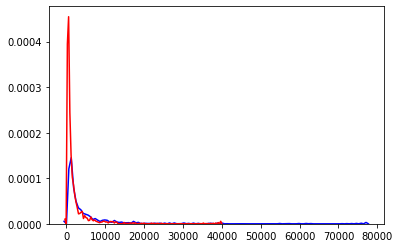

In [ ]:
sns.distplot(q1_pop, hist=False, color='blue')
sns.distplot(q4_pop, hist=False, color='red')
plt.show()

Ttest_indResult(statistic=array([5.98442355]), pvalue=array([2.32708639e-09]))

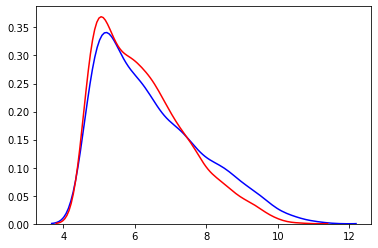

In [ ]:
np.random.seed(123454321)

sns.distplot(np.log(q1_pop), hist=False, color='blue')
sns.distplot(np.log(q4_pop), hist=False, color='red')

stats.ttest_ind(np.log(q1_pop.values), np.log(q4_pop.values), equal_var=False)

In [ ]:
df = spark.read\
.format('csv')\
.option('header', True)\
.option('inferSchema', True)\
.load(DATA_PATH + 'movie_altered.csv')

In [ ]:
print(df.count(), len(df.columns))

4916 12


In [ ]:
df.show(2)

+--------------------+------+------+--------+--------------+-------------------+-----------+----------------+--------------+----------------+----------------+----------------+
|               title|rating|  year|duration|    director_1|director_fb_likes_1|    actor_1|         actor_2|       actor_3|actor_fb_likes_1|actor_fb_likes_2|actor_fb_likes_3|
+--------------------+------+------+--------+--------------+-------------------+-----------+----------------+--------------+----------------+----------------+----------------+
|              Avatar| PG-13|2009.0|   178.0| James Cameron|                0.0|CCH Pounder|Joel David Moore|     Wes Studi|          1000.0|           936.0|           855.0|
|Pirates of the Ca...| PG-13|2007.0|   169.0|Gore Verbinski|              563.0|Johnny Depp|   Orlando Bloom|Jack Davenport|         40000.0|          5000.0|          1000.0|
+--------------------+------+------+--------+--------------+-------------------+-----------+----------------+-----------

## EJERCICIO

---


In [ ]:
DATA_PATH='/content/drive/MyDrive/CURSOS/DATA_SCIENTIST_FUND/2021Q1_DSF_contents/DATA/' 
#movie-ratings/movie_rating_horror.csv

LIBRERIAS A USAR

In [ ]:
from pyspark.sql.functions import expr, col, column, lit
from pyspark.sql.functions import udf, avg
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.functions import col, avg, expr, abs, monotonically_increasing_id, ntile, sum, lit, dense_rank, collect_list
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, LongType


In [ ]:
movies = spark.read.csv(DATA_PATH + 'movie-ratings/movies.csv', header=True, sep=',',inferSchema=True )
ratings = spark.read.csv(DATA_PATH + 'movie-ratings/ratings.csv', header=True, sep=',',inferSchema=True )
tags = spark.read.csv(DATA_PATH + 'movie-ratings/tags.csv', header=True, sep=',',inferSchema=True )

In [ ]:
# sacamos la dimensi`n de cada base 
print('movies')
print(movies.count(), len(movies.columns))
print('ratings')
print(ratings.count(), len(ratings.columns))
print('tags')
print(tags.count(), len(tags.columns))

movies
45843 3
ratings
26024289 4
tags
753170 4
